In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function, division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import os
import pickle
import cv2
import PIL
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
BASE_DIR = './data/coco/'
DATA_DIR = './data/coco2014/'

TRAIN_DATA = 'train2014'
VAL_DATA = 'val2014'

EMB_FILE = 'char-CNN-RNN-embeddings.pickle'
NAME_FILE = 'filenames.pickle'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
import requests
import zipfile
from tqdm import tqdm

def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    
    with open(filename, 'wb') as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)
    progress_bar.close()

# Create directories
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Download COCO dataset
train_url = 'http://images.cocodataset.org/zips/train2014.zip'
val_url = 'http://images.cocodataset.org/zips/val2014.zip'

print('Downloading training images...')
download_file(train_url, os.path.join(BASE_DIR, 'train2014.zip'))

print('Downloading validation images...')
download_file(val_url, os.path.join(BASE_DIR, 'val2014.zip'))

# Extract datasets
print('Extracting training images...')
with zipfile.ZipFile(os.path.join(BASE_DIR, 'train2014.zip'), 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

print('Extracting validation images...')
with zipfile.ZipFile(os.path.join(BASE_DIR, 'val2014.zip'), 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

KeyboardInterrupt: 

In [9]:
# Create necessary directories
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'train'), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, 'val'), exist_ok=True)

# Verify dataset structure
def verify_dataset():
    print("Checking dataset structure...")
    
    # Check directories exist
    dirs_to_check = [
        BASE_DIR,
        DATA_DIR,
        os.path.join(DATA_DIR, TRAIN_DATA),
        os.path.join(DATA_DIR, VAL_DATA),
        os.path.join(BASE_DIR, 'train'),
        os.path.join(BASE_DIR, 'val')
    ]
    
    for d in dirs_to_check:
        if os.path.exists(d):
            print(f"✓ Found directory: {d}")
        else:
            print(f"✗ Missing directory: {d}")
    
    # Count images
    train_images = len(os.listdir(os.path.join(DATA_DIR, TRAIN_DATA))) if os.path.exists(os.path.join(DATA_DIR, TRAIN_DATA)) else 0
    val_images = len(os.listdir(os.path.join(DATA_DIR, VAL_DATA))) if os.path.exists(os.path.join(DATA_DIR, VAL_DATA)) else 0
    
    print(f"\nFound {train_images} training images")
    print(f"Found {val_images} validation images")
    
    # Check pickle files
    pickle_files = [
        os.path.join(BASE_DIR, 'train', NAME_FILE),
        os.path.join(BASE_DIR, 'val', NAME_FILE),
        os.path.join(BASE_DIR, 'train', EMB_FILE),
        os.path.join(BASE_DIR, 'val', EMB_FILE)
    ]
    
    print("\nChecking required pickle files:")
    for f in pickle_files:
        if os.path.exists(f):
            print(f"✓ Found file: {f}")
        else:
            print(f"✗ Missing file: {f}")

verify_dataset()

Checking dataset structure...
✓ Found directory: ./data/coco/
✓ Found directory: ./data/coco2014/
✗ Missing directory: ./data/coco2014/train2014/train2014/
✗ Missing directory: ./data/coco2014/val2014/val2014/
✓ Found directory: ./data/coco/train
✓ Found directory: ./data/coco/val

Found 0 training images
Found 0 validation images

Checking required pickle files:
✓ Found file: ./data/coco/train\filenames.pickle
✓ Found file: ./data/coco/val\filenames.pickle
✗ Missing file: ./data/coco/train\char-CNN-RNN-embeddings.pickle
✗ Missing file: ./data/coco/val\char-CNN-RNN-embeddings.pickle


In [3]:

class MyDataset(Dataset):
    
    def __init__(self, stage=1,base_dir=BASE_DIR, data_dir=DATA_DIR, split='train', transforms=None):
        
        self.base_dir = base_dir
        self.data_dir = data_dir
        if stage == 2:
            self.stage_mag = 4
        else:
            self.stage_mag = 1
            
        if split == 'train':
            self.img_dir = os.path.join(DATA_DIR,TRAIN_DATA)
        else:
            self.img_dir = os.path.join(DATA_DIR, VAL_DATA)
        file_loc = os.path.join(base_dir,split)
        
        files = os.path.join(file_loc,NAME_FILE)
        with open(files,'rb') as f:
            self.filenames = pickle.load(f) 
        self.filenames = [f + '.jpg' for f in self.filenames]
            
        embs = os.path.join(file_loc,EMB_FILE)
        with open(embs,'rb') as f:
            self.embeddings = pickle.load(f,encoding='latin1')
        self.embeddings = np.asarray(self.embeddings)
        
        self.transform = transforms
              
    def __len__(self):
        return len(self.filenames)
    
    def load_img(self, file):
        file = os.path.join(self.img_dir,file)
        img = Image.open(file).convert('RGB')     
        load_size = 76*self.stage_mag
        img = img.resize((load_size, load_size), PIL.Image.BILINEAR)
        if self.transform:
            img = self.transform(img)
        return img
    
    def __getitem__(self,idx):
        img_file = self.filenames[i]
        img = self.load_img(img_file)
        
        embeddings = self.embeddings[idx,:,:]
        seed = np.random.randint(0,embeddings.shape[0]-1)
        embedding = embeddings[seed,:]
        
        return img , embedding


In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(64), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset_stage1 = MyDataset(transforms=transform)


82783
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)
torch.Size([3, 64, 64])
(1024,)


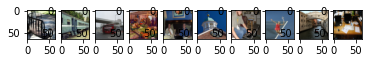

In [5]:
plt.figure()
print(len(dataset_stage1))
for i in range(10):
    img =  dataset_stage1[i][0]
    embedding = dataset_stage1[i][1]
    plt.subplot(1,10,i+1)
    plt.imshow(img.permute(1,2,0)/2+0.5)
    print(img.shape)
    print(embedding.shape)

In [6]:
class upsample(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(upsample, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x = self.up(x)
        return x
    
class expand_G1(nn.Module):
    def __init__(self, inp, nl):
        super(expand_G1,self).__init__()
        self.layers = nl
        self.inp_layers = inp
        self.main = nn.Sequential(
            nn.Linear(inp,4*4*nl),
            nn.BatchNorm1d(4*4*nl),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x = self.main(x)
        return x

    
class cond_aug(nn.Module):
    def __init__(self, inp, out):
        super(cond_aug,self).__init__()
        self.inp_layers = inp
        self.out_layers = out
        self.cond = nn.Linear(inp,out*2)
        self.relu = nn.ReLU()
        
    def process(self,x):
        mean = x[:,:self.out_layers]
        logvar = x[:,self.out_layers:]
        #check
        std = (logvar*0.5).exp()       
        eps = torch.normal(0,1,size=std.size())
        
        return mean, logvar, torch.add(mean,torch.mul(std,eps))
        
    def forward(self,x):
        x = self.cond(x)
        x = self.relu(x)
        return self.process(x)
    
class G1(nn.Module):
    def __init__(self,nz,ng,nl,nc,ne):
        super(G1, self).__init__()
        
        self.embedding_dim = ne
        self.noise_dim = nz
        self.input_dim = ng
        self.num_layers = nl
        self.img_channels = nc
        
        
        self.cond_aug = cond_aug(ne,ng)
        
        self.expand = expand_G1(nz+ng,nl*8)
        
        self.upsample1 = upsample(nl*8,nl*4)
        self.upsample2 = upsample(nl*4,nl*2)
        self.upsample3 = upsample(nl*2,nl)
        self.upsample4 = upsample(nl,nl//2)
        
        self.final = nn.Sequential(
            nn.Conv2d(nl//2,self.img_channels,kernel_size=3,padding=1,stride=1),
            nn.Tanh()
        )
        
    def forward(self,x,z):
        
        mu,logvar, x = self.cond_aug(x)
        
        x = torch.cat((x,z),1)
        
        print(x.shape)
        x = self.expand(x)
        
        x = x.view(-1,self.num_layers*8,4,4)
        
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        
        x = self.final(x)
        return x, mu, logvar
    

In [7]:
class downsample(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(downsample,self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(ch_in,ch_out,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
    def forward(self,x):
        x = self.down(x)
        return x
    
        
class get_logits(nn.Module):
    def __init__(self,ng,nl):
        super(get_logits,self).__init__()
        
        self.final = nn.Sequential(
            nn.Conv2d(nl*4+ng,nl*4,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(nl*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(nl*4,1,kernel_size=4,stride=1,padding=0),
        )
        # remember to do bceloss with logits
        
    def forward(self,img, emb):
        emb = emb.view(-1,emb.size()[1],1,1)
        emb = emb.repeat(1,1,4,4)
        
        img = torch.cat((img,emb),axis=1)
        img = self.final(img)
        
        return img
        
    
class D1(nn.Module):
    def __init__(self,ng,nl,nc,ne):
        super(D1, self).__init__()
        
        self.input_dim = ng
        self.num_layers = nl
        self.img_channels = nc
        self.emb_dim = ne
        
        self.down = nn.Sequential(
            downsample(3,nl//2),
            downsample(nl//2,nl),
            downsample(nl,nl*2),
            downsample(nl*2,nl*4)
        )
        
        
        self.get_logits = get_logits(ng,nl)
        
        
        
    def forward(self,img):
        
        #emb = emb.view(-1,self.input_dim,1,1)
        #emb = emb.repeat(1,1,4,4)
                
        #img = torch.cat((img,emb),1)
        
        #img = self.final(img)
        
        return self.down(img)
        
        

In [8]:
class residual(nn.Module):
    def __init__(self,num):
        super(residual, self).__init__()
        self.num = num
        self.res = nn.Sequential(
            nn.Conv2d(num,num,3,1,1),
            nn.BatchNorm2d(num),
            nn.ReLU(True),
            nn.Conv2d(num,num,3,1,1),
            nn.BatchNorm2d(num)
        )
        self.act = nn.ReLU(True)
        
    def forward(self,x):
        res = x
        x = self.res(x)
        x += res
        x = self.act(x)
        return x
    
class G2(nn.Module):
    def __init__(self,ng,in_size,out_size,nl,ne):
        super(G2, self).__init__()
        self.ng = ng
        self.in_size = in_size
        self.out_size = out_size
        self.num_layer = nl
        self.emb_dim = ne
        
        self.down = nn.Sequential(
            nn.Conv2d(3,nl,3,1,1),
            nn.ReLU(True),
            nn.Conv2d(nl,2*nl,4,2,1),
            nn.BatchNorm2d(2*nl),
            nn.ReLU(True),
            nn.Conv2d(nl*2,nl*4,4,2,1),
            nn.BatchNorm2d(4*nl),
            nn.ReLU(True)
        )
        
        self.ca = cond_aug(ne,ng)
        
        self.join = nn.Sequential(
            nn.Conv2d(nl*4+ng,nl*4,3,1,1),
            nn.BatchNorm2d(nl*4),
            nn.ReLU(True),
        )
        
        self.res1 = residual(nl*4)
        self.res2 = residual(nl*4)
        
        self.up1 = upsample(nl*4,nl*2)
        self.up2 = upsample(nl*2,nl)
        self.up3 = upsample(nl,nl//2)
        self.up4 = upsample(nl//2,nl//4)
        
        self.final = nn.Sequential(
            nn.Conv2d(nl//4,3,3,1,1),
            nn.Tanh()
        )
        
    def forward(self,x,img):
        mu, logvar, x = self.ca(x)
        x = x.view(-1,self.ng,1,1)
        x = x.repeat(1,1,16,16)
        print(x.shape)
        
        img = self.down(img)
        print(img.shape)
        img = torch.cat((img,x),axis=1)
        
        img = self.join(img)
        
        img = self.res1(img)
        img = self.res2(img)
        
        img = self.up1(img)
        img = self.up2(img)
        img = self.up3(img)
        img = self.up4(img)
        
        img = self.final(img)
        
        return img, mu, logvar
        

In [9]:
class D2(nn.Module):
    def __init__(self,ng,nl,nc):
        super(D2,self).__init__()
        self.input_dim = ng
        self.num_layers = nl
        self.num_channels = nc
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(nc,nl//2,4,2,1),
            nn.LeakyReLU(0.2,True),
        )
        
        self.down = nn.Sequential(
            downsample(nl//2,nl),
            downsample(nl,nl*2),
            downsample(nl*2,nl*4),
            downsample(nl*4,nl*8),
            downsample(nl*8,nl*16),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(nl*16,nl*8,3,1,1),
            nn.BatchNorm2d(nl*8),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(nl*8,nl*4,3,1,1),
            nn.BatchNorm2d(nl*4),
            nn.LeakyReLU(0.2,True),
        )
        
        self.get_logits = get_logits(ng,nl)
        
    def forward(self,img):
        
        img = self.conv1(img)
        img = self.down(img)
        img = self.conv2(img)
        
        return img
        

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

In [11]:
Noise_Dim = 100
Cond_Dim = 128
Layers_G1 = 128
Layers_D1 = 128
Layers_G2 = 128
Layers_D2 = 128
Emb_Dim = 1024
dis1_lr = 0.01
gen1_lr = 0.01
decay_interval_1 = 10
betas = (0.5,0.999)
IMG_Channels = 3

torch.Size([10, 3, 64, 64])
torch.Size([10, 1024])
tensor([-0.3594, -0.0229,  0.2266, -0.1709, -0.0154])


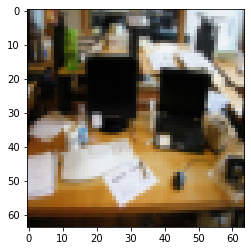

In [12]:
batch_size = 10

dataloader1 = DataLoader(dataset_stage1, batch_size=10,pin_memory=True,drop_last=True,num_workers=2)
i_batch, e_batch = next(iter(dataloader1))
print(i_batch.shape)
print(e_batch.shape)
fixed_embedding = e_batch
plt.imshow(i_batch[1].permute(1,2,0)/2 + 0.5)
print(e_batch[1][0:5])    

In [13]:
num_epochs = 0
total_iters = 0
decay_interval1 = 100

In [14]:
Gen1 = G1(Noise_Dim,Layers_G1,Layers_D1,IMG_Channels,Emb_Dim).to(device)
Gen1.apply(weights_init)
Dis1 = D1(Layers_G1,Layers_D1,IMG_Channels,Emb_Dim).to(device)
Dis1.apply(weights_init)

real_labels = 0.9*torch.ones(batch_size,device=device) + 0.1*torch.rand(batch_size,device=device)
fake_labels = torch.zeros(batch_size,device=device)
fixed_noise1 = torch.randn(batch_size, Noise_Dim, 1, 1, device=device)

opt_d1 = torch.optim.Adam(Dis1.parameters(),lr=dis1_lr, betas=(0.5, 0.999))
opt_g1 = torch.optim.Adam(Gen1.parameters(),lr=gen1_lr, betas=(0.5, 0.999))

x = torch.normal(0,1,size=(3,1024))
z = torch.normal(0,1,size=(3,100))
y, mu, logvar = Gen1(x,z)
print(y.shape)

torch.Size([3, 228])
torch.Size([3, 3, 64, 64])


In [15]:
new_epochs = 1
curr_run_epoch = 0
random_images = []
G_loss = []
D_loss = []
for epoch in range(num_epochs,num_epochs+new_epochs):
    if num_epochs % decay_interval1 and num_epochs > 0:
        gen1_lr *= 0.5
        dis1_lr *= 0.5
        for p in opt_g1.param_groups:
            p['lr'] = gen1_lr
        for p in opt_d1.param_groups:
            p['lr'] = den1_lr
        #decrease learning rate
    for i,data in enumerate(dataloader1,0):
        real_img,real_embed = data
        #print(type(data))
        #print(type(data[0]))
        real_img = real_img.to(device)
        real_embed = real_embed.to(device)
        noise_d = torch.randn(batch_size,Noise_Dim,device=device)
    
        fake_img_disc,mean_d,var_d = Gen1(real_embed,noise_d)
        fake_img_disc = fake_img_disc.detach()
        mean_d = mean_d.detach()
        var_d = var_d.detach()
        
        opt_d1.zero_grad()
        criterion = nn.BCEWithLogitsLoss()
        real_d1_feature = Dis1(real_img)
        fake_d1_feature = Dis1(fake_img_disc)
        d1_real_op = Dis1.get_logits(real_d1_feature,mean_d)
        d1_fake_op = Dis1.get_logits(fake_d1_feature,mean_d)
    
        wrong_mean_d = torch.roll(mean_d,1,0)
        d1_mislabel_op = Dis1.get_logits(real_d1_feature,wrong_mean_d)
        dloss_real = criterion(d1_real_op.squeeze(),real_labels)
        dloss_fake = criterion(d1_fake_op.squeeze(),fake_labels)
        dloss_mislabel = criterion(d1_mislabel_op.squeeze(),fake_labels)
        dloss_total = dloss_real + 0.5*(dloss_fake+dloss_mislabel)
        D_loss.append(dloss_total.item())
        
        dloss_total.backward()
        opt_d1.step()
        
        #train generator
        opt_g1.zero_grad()
        noise_g = torch.randn(batch_size,Noise_Dim,device=device)
        fake_img_gen,mean_g,var_g = Gen1(real_embed,noise_g)
        mean_gd = mean_g.detach()
        fake_img_g = Dis1(fake_img_gen)
        g1_fake_op = Dis1.get_logits(fake_img_g,mean_gd)
        gloss = criterion(g1_fake_op.squeeze(),real_labels)
        G_loss.append(gloss.item())
        gloss.backward()
        
        opt_g1.step()
        total_iters += 1
        if i%1 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tReal_Loss_D: %.4f\tFake/Mislabeled_Loss_D: %.4f / %.4f'
                  % (epoch, num_epochs+new_epochs, i, len(dataloader1),
                     dloss_total.item(), gloss.item(), dloss_real.item(), dloss_fake.item(), dloss_mislabel.item()))
                
        if (total_iters % 100 == 0) or ((epoch == num_epochs+new_epochs-1) and (i == len(dataloader1)-1)):
            with torch.no_grad():
                fake_fixed = Gen1(fixed_noise,fixed_embedding)[0].detach().cpu()
            random_images.append(vutils.make_grid(fake_fixed, padding=2, normalize=True))
            
        if i==5:
            break
        break
    print(epoch)
    num_epochs += 1
    torch.save(Gen1.state_dict(),f"/kaggle/working/netG1_{epoch}.pt")
    torch.save(Dis1.state_dict(),f"/kaggle/working/netD1_{epoch}.pt")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

torch.Size([10, 228])
torch.Size([10, 228])
[0/1][0/8278]	Loss_D: 1.9141	Loss_G: 64.7833	Real_Loss_D: 0.4634	Fake/Mislabeled_Loss_D: 1.5495 / 1.3520
0
